In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "gaussian_peak"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 21)
y_train shape: (4000, 3)
X_test shape: (1000, 21)
y_test shape: (1000, 3)


In [5]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

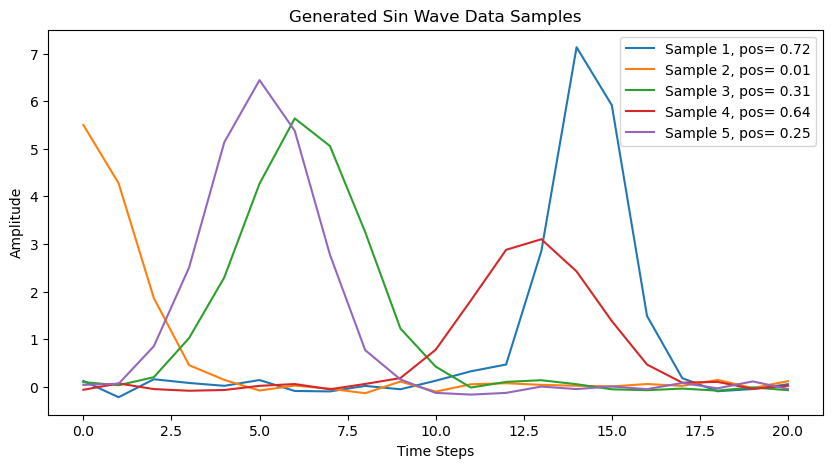

In [6]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, pos= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

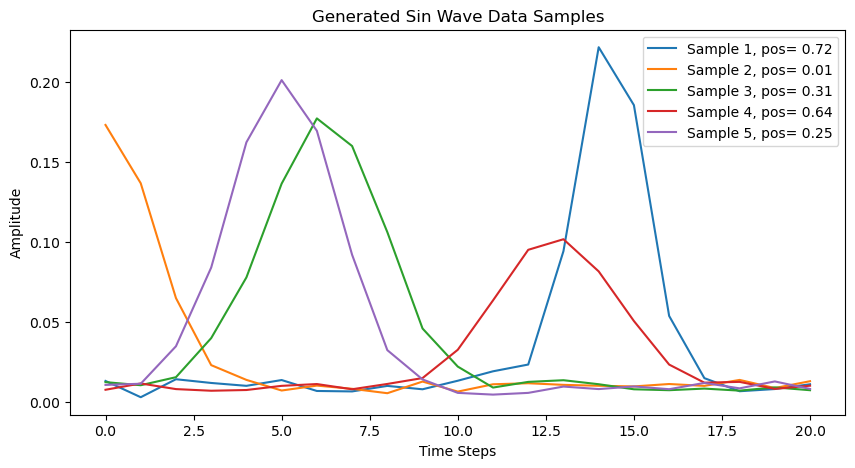

In [7]:
# normalize data to [0, 1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, pos= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [8]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 4,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [9]:
y_train.shape

(150, 3)

In [ ]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size, 0], dtype=torch.float64 # only predict peak positions
        )
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=True) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]]), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.0366,  0.0287,  0.0025,  0.0132,  0.0610,  0.0395,  0.0137,  0.0338,
         0.0462,  0.0622,  0.0108,  0.0450,  0.0324,  0.0409,  0.0228,  0.0618,
         0.0321, -0.0041,  0.0326,  0.0520,  0.0304,  0.0844,  0.0242,  0.0699,
         0.0089,  0.0067,  0.0230,  0.0264,  0.0658,  0.0116,  0.0410,  0.0055],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3561, RMSE: 0.5967
Batch 2 loss: 0.3307, RMSE: 0.5751
Batch 3 loss: 0.1862, RMSE: 0.4315
Batch 4 loss: 0.3673, RMSE: 0.6060
Batch 5 loss: 0.2389, RMSE: 0.4888
Batch 6 loss: 0.3282, RMSE: 0.5729
Batch 7 loss: 0.1993, RMSE: 0.4464
Batch 8 loss: 0.1725, RMSE: 0.4153
Batch 9 loss: 0.1933, RMSE: 0.4396
Batch 10 loss: 0.1497, RMSE: 0.3869
Epoch 1 train loss: 0.25221343606046476


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1221, RMSE: 0.3495
Batch 2 loss: 0.1058, RMSE: 0.3253
Batch 3 loss: 0.0473, RMSE: 0.2176
Batch 4 loss: 0.1045, RMSE: 0.3233
Batch 5 loss: 0.0976, RMSE: 0.3124
Batch 6 loss: 0.1164, RMSE: 0.3412
Batch 7 loss: 0.0644, RMSE: 0.2538
Batch 8 loss: 0.1147, RMSE: 0.3387
Batch 9 loss: 0.1199, RMSE: 0.3463
Batch 10 loss: 0.0635, RMSE: 0.2520
Epoch 2 train loss: 0.09562992125524784


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0789, RMSE: 0.2809
Batch 2 loss: 0.1352, RMSE: 0.3677
Batch 3 loss: 0.1064, RMSE: 0.3261
Batch 4 loss: 0.0841, RMSE: 0.2899
Batch 5 loss: 0.0583, RMSE: 0.2414
Batch 6 loss: 0.0697, RMSE: 0.2641
Batch 7 loss: 0.1009, RMSE: 0.3177
Batch 8 loss: 0.0701, RMSE: 0.2647
Batch 9 loss: 0.1157, RMSE: 0.3402
Batch 10 loss: 0.0516, RMSE: 0.2272
Epoch 3 train loss: 0.0870877261064019


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1181, RMSE: 0.3437
Batch 2 loss: 0.0571, RMSE: 0.2390
Batch 3 loss: 0.0794, RMSE: 0.2817
Batch 4 loss: 0.0734, RMSE: 0.2709
Batch 5 loss: 0.0934, RMSE: 0.3057
Batch 6 loss: 0.1221, RMSE: 0.3495
Batch 7 loss: 0.0825, RMSE: 0.2872
Batch 8 loss: 0.0573, RMSE: 0.2394
Batch 9 loss: 0.0903, RMSE: 0.3004
Batch 10 loss: 0.0643, RMSE: 0.2535
Epoch 4 train loss: 0.08378891096858991


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1038, RMSE: 0.3222
Batch 2 loss: 0.0963, RMSE: 0.3103
Batch 3 loss: 0.0633, RMSE: 0.2516
Batch 4 loss: 0.0782, RMSE: 0.2796
Batch 5 loss: 0.0873, RMSE: 0.2954
Batch 6 loss: 0.0948, RMSE: 0.3079
Batch 7 loss: 0.0776, RMSE: 0.2786
Batch 8 loss: 0.0472, RMSE: 0.2174
Batch 9 loss: 0.0605, RMSE: 0.2460
Batch 10 loss: 0.1293, RMSE: 0.3596
Epoch 5 train loss: 0.08383621461176631


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1257, RMSE: 0.3545
Batch 2 loss: 0.0747, RMSE: 0.2734
Batch 3 loss: 0.0801, RMSE: 0.2830
Batch 4 loss: 0.0606, RMSE: 0.2462
Batch 5 loss: 0.0873, RMSE: 0.2954
Batch 6 loss: 0.0827, RMSE: 0.2876
Batch 7 loss: 0.0984, RMSE: 0.3137
Batch 8 loss: 0.0973, RMSE: 0.3120
Batch 9 loss: 0.0645, RMSE: 0.2540
Batch 10 loss: 0.0548, RMSE: 0.2341
Epoch 6 train loss: 0.08261858518702599


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0771, RMSE: 0.2777
Batch 2 loss: 0.0777, RMSE: 0.2788
Batch 3 loss: 0.0564, RMSE: 0.2375
Batch 4 loss: 0.1078, RMSE: 0.3283
Batch 5 loss: 0.1039, RMSE: 0.3224
Batch 6 loss: 0.0501, RMSE: 0.2239
Batch 7 loss: 0.0691, RMSE: 0.2629
Batch 8 loss: 0.0963, RMSE: 0.3104
Batch 9 loss: 0.1127, RMSE: 0.3356
Batch 10 loss: 0.0714, RMSE: 0.2671
Epoch 7 train loss: 0.08225407975209571


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0563, RMSE: 0.2374
Batch 2 loss: 0.0607, RMSE: 0.2463
Batch 3 loss: 0.0911, RMSE: 0.3019
Batch 4 loss: 0.0730, RMSE: 0.2702
Batch 5 loss: 0.0937, RMSE: 0.3061
Batch 6 loss: 0.1094, RMSE: 0.3308
Batch 7 loss: 0.0855, RMSE: 0.2924
Batch 8 loss: 0.0638, RMSE: 0.2525
Batch 9 loss: 0.0951, RMSE: 0.3083
Batch 10 loss: 0.0766, RMSE: 0.2769
Epoch 8 train loss: 0.08052632348329809


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0928, RMSE: 0.3046
Batch 2 loss: 0.0651, RMSE: 0.2551
Batch 3 loss: 0.0620, RMSE: 0.2490
Batch 4 loss: 0.1063, RMSE: 0.3260
Batch 5 loss: 0.0899, RMSE: 0.2999
Batch 6 loss: 0.0871, RMSE: 0.2951
Batch 7 loss: 0.0668, RMSE: 0.2584
Batch 8 loss: 0.0909, RMSE: 0.3015
Batch 9 loss: 0.0979, RMSE: 0.3129
Batch 10 loss: 0.0850, RMSE: 0.2916
Epoch 9 train loss: 0.08436801827918222


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0828, RMSE: 0.2878
Batch 2 loss: 0.0858, RMSE: 0.2929
Batch 3 loss: 0.0905, RMSE: 0.3008
Batch 4 loss: 0.0928, RMSE: 0.3047
Batch 5 loss: 0.0403, RMSE: 0.2007
Batch 6 loss: 0.0783, RMSE: 0.2798
Batch 7 loss: 0.0993, RMSE: 0.3150
Batch 8 loss: 0.0633, RMSE: 0.2515
Batch 9 loss: 0.0859, RMSE: 0.2931
Batch 10 loss: 0.1170, RMSE: 0.3420
Epoch 10 train loss: 0.08358284108850653


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0759, RMSE: 0.2754
Batch 2 loss: 0.0512, RMSE: 0.2262
Batch 3 loss: 0.0826, RMSE: 0.2874
Batch 4 loss: 0.1304, RMSE: 0.3612
Batch 5 loss: 0.0856, RMSE: 0.2926
Batch 6 loss: 0.0802, RMSE: 0.2832
Batch 7 loss: 0.0580, RMSE: 0.2407
Batch 8 loss: 0.1093, RMSE: 0.3307
Batch 9 loss: 0.0831, RMSE: 0.2882
Batch 10 loss: 0.0562, RMSE: 0.2370
Epoch 11 train loss: 0.08123645861682288


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0956, RMSE: 0.3091
Batch 2 loss: 0.0879, RMSE: 0.2965
Batch 3 loss: 0.0578, RMSE: 0.2404
Batch 4 loss: 0.0982, RMSE: 0.3134
Batch 5 loss: 0.1067, RMSE: 0.3267
Batch 6 loss: 0.0667, RMSE: 0.2582
Batch 7 loss: 0.0814, RMSE: 0.2853
Batch 8 loss: 0.0870, RMSE: 0.2949
Batch 9 loss: 0.0743, RMSE: 0.2725
Batch 10 loss: 0.0594, RMSE: 0.2438
Epoch 12 train loss: 0.0814917058350737


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0563, RMSE: 0.2374
Batch 2 loss: 0.0785, RMSE: 0.2802
Batch 3 loss: 0.0599, RMSE: 0.2448
Batch 4 loss: 0.1131, RMSE: 0.3364
Batch 5 loss: 0.0724, RMSE: 0.2691
Batch 6 loss: 0.0594, RMSE: 0.2437
Batch 7 loss: 0.1040, RMSE: 0.3225
Batch 8 loss: 0.0656, RMSE: 0.2561
Batch 9 loss: 0.0973, RMSE: 0.3119
Batch 10 loss: 0.1369, RMSE: 0.3700
Epoch 13 train loss: 0.08434621352189514


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0648, RMSE: 0.2546
Batch 2 loss: 0.0717, RMSE: 0.2677
Batch 3 loss: 0.1015, RMSE: 0.3186
Batch 4 loss: 0.0663, RMSE: 0.2574
Batch 5 loss: 0.0806, RMSE: 0.2838
Batch 6 loss: 0.0823, RMSE: 0.2868
Batch 7 loss: 0.0767, RMSE: 0.2769
Batch 8 loss: 0.0782, RMSE: 0.2796
Batch 9 loss: 0.1075, RMSE: 0.3278
Batch 10 loss: 0.0823, RMSE: 0.2869
Epoch 14 train loss: 0.0811711943625677


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0960, RMSE: 0.3098
Batch 2 loss: 0.0852, RMSE: 0.2920
Batch 3 loss: 0.0813, RMSE: 0.2851
Batch 4 loss: 0.0712, RMSE: 0.2669
Batch 5 loss: 0.0931, RMSE: 0.3050
Batch 6 loss: 0.0962, RMSE: 0.3101
Batch 7 loss: 0.0669, RMSE: 0.2587
Batch 8 loss: 0.0541, RMSE: 0.2326
Batch 9 loss: 0.0830, RMSE: 0.2881
Batch 10 loss: 0.0820, RMSE: 0.2863
Epoch 15 train loss: 0.08089638894618488


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1097, RMSE: 0.3312
Batch 2 loss: 0.0820, RMSE: 0.2863
Batch 3 loss: 0.0568, RMSE: 0.2384
Batch 4 loss: 0.0906, RMSE: 0.3010
Batch 5 loss: 0.0711, RMSE: 0.2667
Batch 6 loss: 0.0715, RMSE: 0.2674
Batch 7 loss: 0.0831, RMSE: 0.2882
Batch 8 loss: 0.0951, RMSE: 0.3083
Batch 9 loss: 0.0595, RMSE: 0.2439
Batch 10 loss: 0.0874, RMSE: 0.2956
Epoch 16 train loss: 0.08067808243667354


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0489, RMSE: 0.2210
Batch 2 loss: 0.0969, RMSE: 0.3112
Batch 3 loss: 0.0791, RMSE: 0.2812
Batch 4 loss: 0.0647, RMSE: 0.2543
Batch 5 loss: 0.1048, RMSE: 0.3238
Batch 6 loss: 0.0796, RMSE: 0.2822
Batch 7 loss: 0.0932, RMSE: 0.3053
Batch 8 loss: 0.0715, RMSE: 0.2675
Batch 9 loss: 0.0851, RMSE: 0.2918
Batch 10 loss: 0.0622, RMSE: 0.2493
Epoch 17 train loss: 0.07860260528709687


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0802, RMSE: 0.2832
Batch 2 loss: 0.1035, RMSE: 0.3217
Batch 3 loss: 0.0925, RMSE: 0.3041
Batch 4 loss: 0.0826, RMSE: 0.2874
Batch 5 loss: 0.0580, RMSE: 0.2408
Batch 6 loss: 0.0614, RMSE: 0.2478
Batch 7 loss: 0.0835, RMSE: 0.2890
Batch 8 loss: 0.0646, RMSE: 0.2541
Batch 9 loss: 0.0917, RMSE: 0.3028
Batch 10 loss: 0.0795, RMSE: 0.2819
Epoch 18 train loss: 0.07973672785785757


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0876, RMSE: 0.2960
Batch 2 loss: 0.0969, RMSE: 0.3113
Batch 3 loss: 0.0517, RMSE: 0.2274
Batch 4 loss: 0.0923, RMSE: 0.3037
Batch 5 loss: 0.0584, RMSE: 0.2416
Batch 6 loss: 0.0583, RMSE: 0.2415
Batch 7 loss: 0.0774, RMSE: 0.2782
Batch 8 loss: 0.1013, RMSE: 0.3183
Batch 9 loss: 0.0860, RMSE: 0.2932
Batch 10 loss: 0.0741, RMSE: 0.2723
Epoch 19 train loss: 0.07840023949121858


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0627, RMSE: 0.2504
Batch 2 loss: 0.0734, RMSE: 0.2710
Batch 3 loss: 0.1046, RMSE: 0.3234
Batch 4 loss: 0.0908, RMSE: 0.3013
Batch 5 loss: 0.1132, RMSE: 0.3364
Batch 6 loss: 0.0522, RMSE: 0.2286
Batch 7 loss: 0.0694, RMSE: 0.2635
Batch 8 loss: 0.0902, RMSE: 0.3003
Batch 9 loss: 0.0457, RMSE: 0.2137
Batch 10 loss: 0.0768, RMSE: 0.2770
Epoch 20 train loss: 0.07788774901417952


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0530, RMSE: 0.2303


In [ ]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)[:, 0]  # only predict peak positions
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0006377757983934177
RMSE: 0.025254223377356465
final parameters:
{'positions': tensor([[-14.2442,   0.0000],
        [ -6.9050,   0.0000],
        [  0.1674,   0.0000],
        [  6.9710,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.4835, 1.1001, 1.3374, 1.0627], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1.0351, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5694, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.1741, -0.0289,  0.2611, -0.1053,  0.1345, -0.3105, -0.0020,  0.1368,
         0.3553,  0.4510, -0.0941,  0.0855,  0.2858,  0.3973,  0.1204,  0.0947],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor([[ 5.3881e-05,  1.2462e-05, -1.1110e-05, -1.6500e-05,  

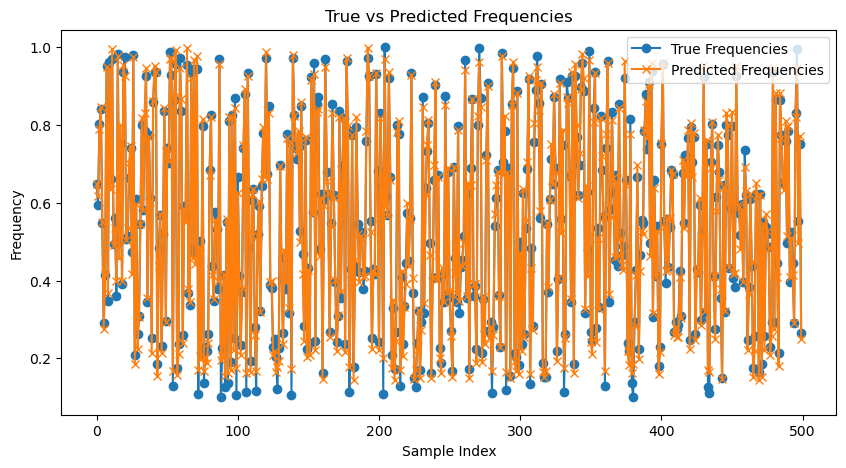

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Peak", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Peak", marker='x')
plt.title("True vs Predicted Peak")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

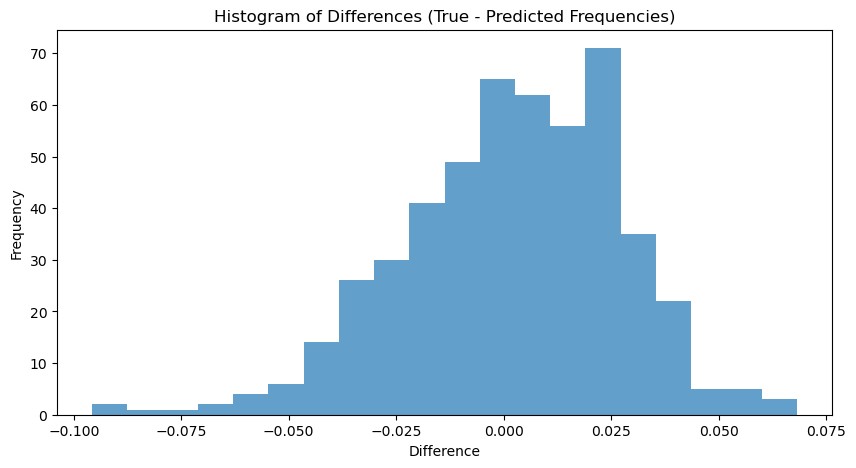

In [ ]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Peak)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

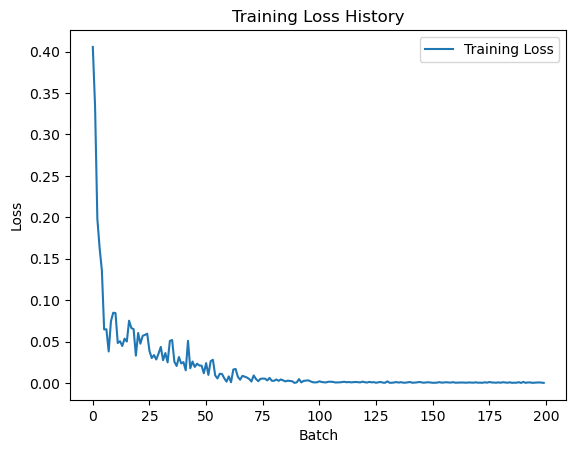

In [ ]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [ ]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [ ]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

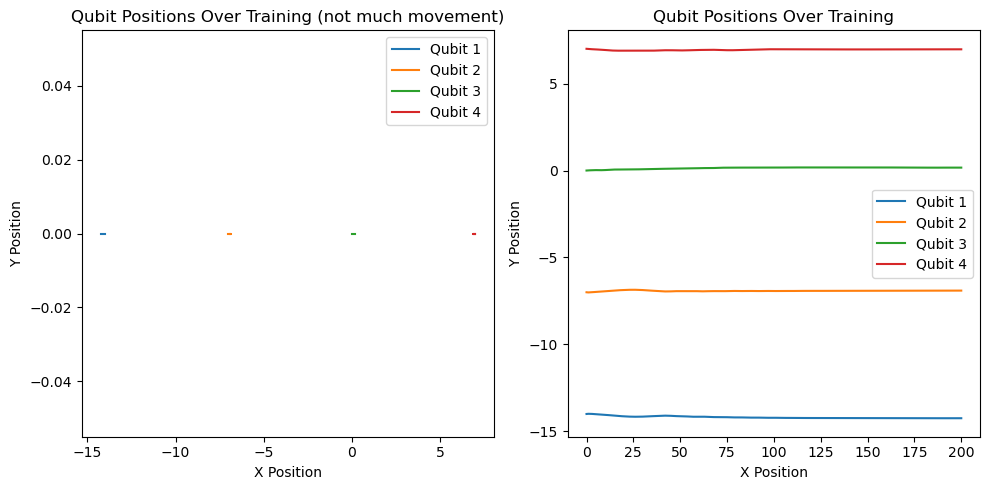

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

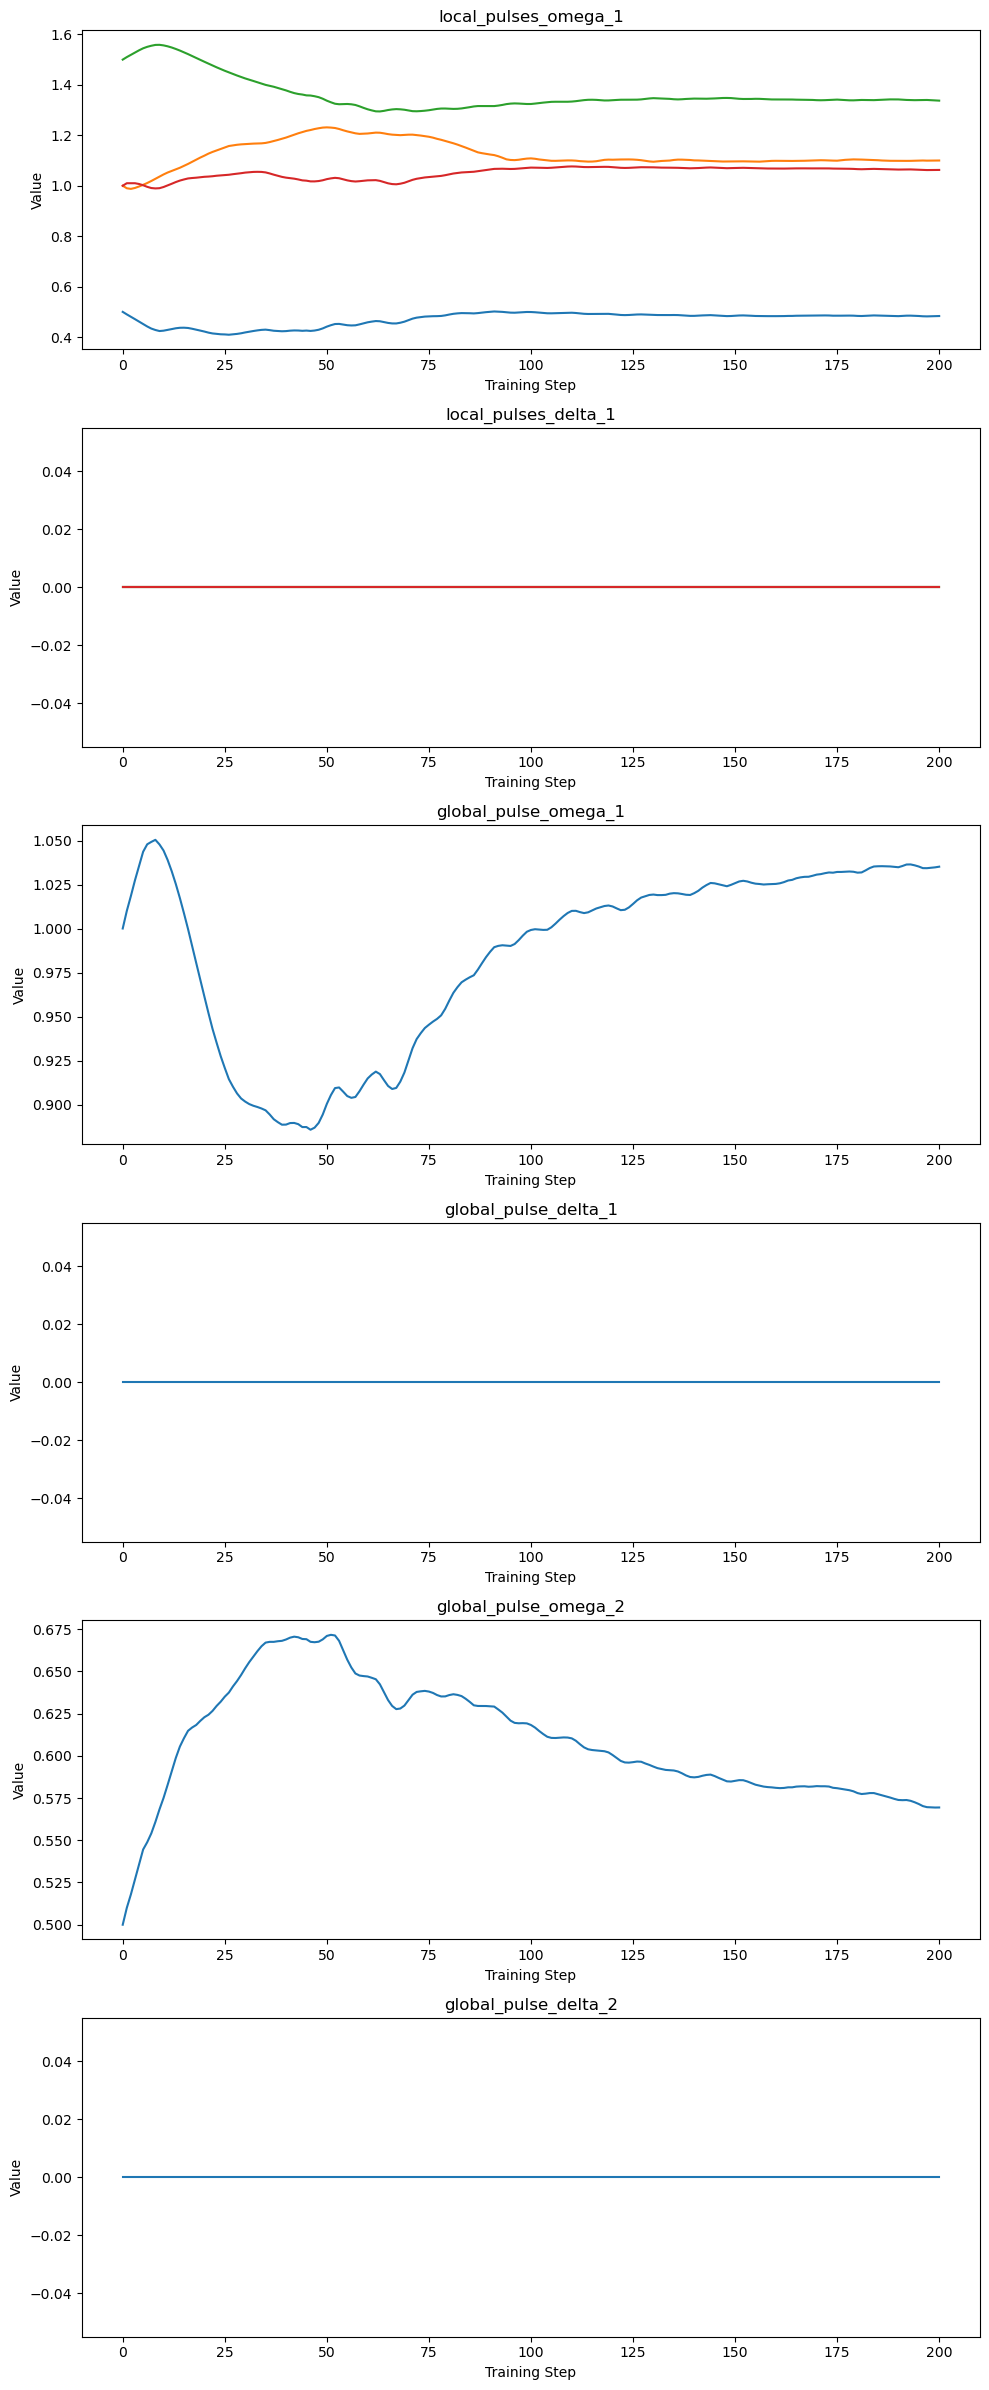

In [ ]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [ ]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_GaussPeak_dist_grad_false_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 151
